# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [273]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics 
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1. Data Overview

## 1.1 Transcript Dataset

In [434]:
# get a quick data overview

In [435]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [436]:
#check for missing data
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [437]:
transcript.shape

(306534, 4)

## 1.2 Profile Dataset

In [277]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [278]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [279]:
profile.shape

(17000, 5)

## 1.3 Portfolio Dataset

In [280]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [281]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [282]:
portfolio.shape

(10, 6)

# 2. Data Cleaning

## 2.1 Transcript dataset

In [161]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [284]:
#drop transactions in order to avoid false transaction attribution
df_offer = transcript[transcript['event'] != 'transaction']
df_offer.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [285]:
# read offer id from the value column
df_offer = df_offer.copy()
df_offer[['offer id','offer_id', 'reward']] = df_offer['value'].apply(pd.Series)
df_offer['oid'] = df_offer['offer id'].combine_first(df_offer['offer_id'])
df_offer = df_offer.drop(columns=['offer id', 'offer_id', 'reward', 'value'])
df_offer = df_offer.rename(columns={'oid': "offer_id", 'person': 'user_id'})
df_offer.head()


,user_id,event,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [286]:
def create_dummies(df, cat_columns):
    """
    Create dummy variables for categorical variables
    
    Parameters
    ----------
    df: input data frame
    cat_columns: list of categorical variables
    
    Returns
    -------
    df: data frame with categorical variables transformed into dummy variables
    
    """

    df = pd.get_dummies(df, columns = cat_columns)

    return df


In [287]:
df_offer = create_dummies(df_offer,['event'])

In [288]:
df_offer.head()

,user_id,time,offer_id,event_offer completed,event_offer received,event_offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0


In [291]:
df_offer_grouped = df_offer.groupby(['user_id','offer_id']).sum().reset_index()
df_offer_grouped.head(5)

,user_id,offer_id,time,event_offer completed,event_offer received,event_offer viewed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1152,1,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,708,0,1,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,360,0,1,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1278,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1572,1,1,1


In order to evaluate whether offer was successful or not we will create a new event event_offer_viewed - it will only be set if a specific user viewed and completed an offer. 

In [438]:
df_offer_grouped['offer_success'] = df_offer_grouped.apply(lambda x: 1 if x['event_offer viewed'] == 1 and x['event_offer completed'] == 1 else 0, axis=1)

In [439]:
df_offer_grouped.head()

,user_id,offer_id,time,event_offer completed,event_offer received,event_offer viewed,offer_success
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1152,1,1,0,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,708,0,1,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,360,0,1,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1278,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1572,1,1,1,1


In [317]:
df_offer_success = df_offer_grouped.drop(columns = ['time','event_offer completed', 'event_offer received', 'event_offer viewed'])
df_offer_success.head()

,user_id,offer_id,offer_success
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1


## 2.2 Profile Dataset

In [299]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [300]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [301]:
profile[profile['gender'].isnull()].head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


In [302]:
profile = profile.dropna()

In [303]:
profile.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [ ]:
#introducing a new variable age_group for an easier exploratory data analysis

In [304]:
def age_group(df):
    """
    Add age group to the dataframe based on the age
        
    Parameters
    ----------   
    df: data frame
    
    Returns
    -------
    df: output data frame with age_group column
    """
    
    #add age_group column
    df.loc[(df.age < 20) , 'age_group'] = 'under 20'
    df.loc[(df.age >= 20) & (df.age <= 45) , 'age_group'] = '20-45'
    df.loc[(df.age >= 46) & (df.age <= 60) , 'age_group'] = '46-60'
    df.loc[(df.age >= 61) , 'age_group'] = '61-80'
    return df


In [305]:
df_profile = age_group(profile)

In [306]:
# rename columns for id into user_id
df_profile = df_profile.rename(columns={'id':'user_id'})

In [307]:
#convert values into a proper type
df_profile['became_member_on'] = pd.to_datetime(df_profile['became_member_on'], format='%Y%m%d')

In [308]:
#create new column and calculate length of membership in the program
df_profile['membership_days'] = (datetime.now() - df_profile['became_member_on']).dt.days
df_profile = df_profile.drop('became_member_on',1)


In [195]:
df_profile.head()

,gender,age,user_id,income,age_group,membership_days
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,46-60,2088
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,61-80,2155
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,61-80,1803
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,61-80,1879
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,46-60,1969


## 2.3 Portfolio Dataset

In [309]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [310]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [311]:
#rename id into offer_id
df_portfolio = portfolio.rename(columns={'id': "offer_id"})

In [233]:
#create dummies for channels

In [312]:
#process channels into dummy variable
df_clean_dummy = df_portfolio.copy()
dummy = pd.get_dummies(df_portfolio.channels.apply(pd.Series).stack()).sum(level=0)
df_clean_dummy = pd.concat([df_clean_dummy, dummy], axis=1)
df_portfolio = df_clean_dummy.drop(columns='channels')

In [251]:
df_portfolio_dummy.head()

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


## 2.4 Merging datasets 

In [318]:
df_merged = pd.merge(df_offer_success, df_profile, how = 'inner')
df_merged = pd.merge(df_merged, df_portfolio, how = 'inner')


In [319]:
df_merged.head()

,user_id,offer_id,offer_success,gender,age,income,age_group,membership_days,reward,difficulty,duration,offer_type,email,mobile,social,web
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,M,33,72000.0,20-45,2173,2,10,7,discount,1,1,0,1
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,0,F,19,65000.0,under 20,2428,2,10,7,discount,1,1,0,1
2,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,0,M,56,47000.0,46-60,1941,2,10,7,discount,1,1,0,1
3,00715b6e55c3431cb56ff7307eb19675,2906b810c7d4411798c6938adc9daaa5,1,F,58,119000.0,46-60,1943,2,10,7,discount,1,1,0,1
4,00840a2ca5d2408e982d56544dc14ffd,2906b810c7d4411798c6938adc9daaa5,1,M,26,61000.0,20-45,3025,2,10,7,discount,1,1,0,1


In [320]:
df_merged.isnull().sum()

user_id            0
offer_id           0
offer_success      0
gender             0
age                0
income             0
age_group          0
membership_days    0
reward             0
difficulty         0
duration           0
offer_type         0
email              0
mobile             0
social             0
web                0
dtype: int64

In [321]:
df_merged.shape

(55222, 16)

# 3. Exploratory Data Analysis

## 3.1 Merged Dataset Overview

In [322]:
df_merged.describe()

,offer_success,age,income,membership_days,reward,difficulty,duration,email,mobile,social,web
count,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.0,55222.000000,55222.000000,55222.000000
mean,0.335627,54.349969,65388.595125,2233.272084,4.204737,7.718554,6.508239,1.0,0.898808,0.599181,0.799337
std,0.472213,17.392733,21626.373809,419.339533,3.402301,5.547981,2.205656,0.0,0.301585,0.490069,0.400500
min,0.000000,18.000000,30000.000000,1712.000000,0.000000,0.000000,3.000000,1.0,0.000000,0.000000,0.000000
25%,0.000000,42.000000,49000.000000,1919.000000,2.000000,5.000000,5.000000,1.0,1.000000,0.000000,1.000000
50%,0.000000,55.000000,63000.000000,2069.000000,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000
75%,1.000000,66.000000,80000.000000,2508.000000,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000
max,1.000000,101.000000,120000.000000,3535.000000,10.000000,20.000000,10.000000,1.0,1.000000,1.000000,1.000000


## 3.2 Age Distribution

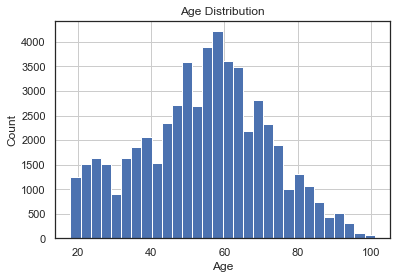

In [323]:
df_merged.age.hist(bins = 30)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution');

The average Starbucks valid user is 55 years old. The youngest users are 18 years old (probably corresponds to the lowest age that is legally allowed to participate in the program) and the oldest one is 101 years old. Based on the distribution we can conclude that the majority of the users lies within the range of 45 to 70. 

## 3.3. Income Distribution

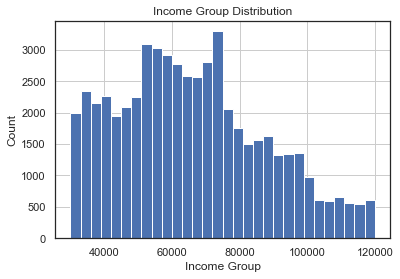

In [324]:
df_merged.income.hist(bins = 30)
plt.xlabel('Income Group')
plt.ylabel('Count')
plt.title('Income Group Distribution');

An average income of the Starbucks user is 65 TSD per year. Based on the distribution above we can make a conclusion that the core group of Starbucks users lies within an income range of 50 to 80 TSD per year.

## 3.4 Membership Duration Distribution

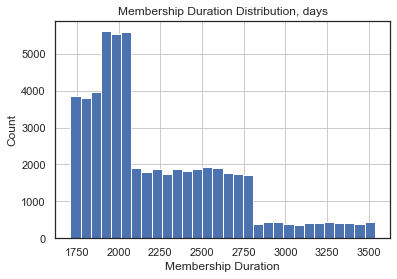

In [325]:
df_merged.membership_days.hist(bins = 30)
plt.xlabel('Membership Duration')
plt.ylabel('Count')
plt.title('Membership Duration Distribution, days');

## 3.5 Gender Distribution

<AxesSubplot:ylabel='gender'>

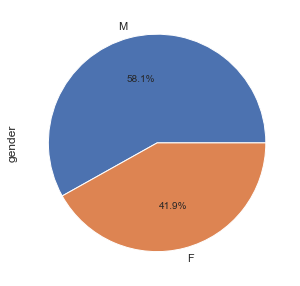

In [326]:
#share of males and females
plot_gender = df_merged[df_merged['gender'] != 'O']
plot_gender.gender.value_counts().plot(kind='pie' , figsize=(5, 5), autopct='%1.1f%%')

The Starbucks audience is predominantly male

## 3.6 Gender distribution per Age Group

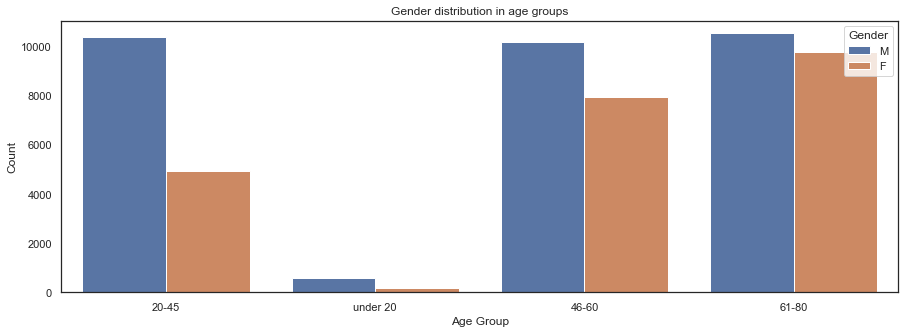

In [327]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "age_group", hue= "gender", data=plot_gender)
sns.set(style="white")
plt.title('Gender distribution in age groups')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender')

Males are overrepresented in all groups except 61-80. 

## 3.7 Gender Distribution per Offer Type

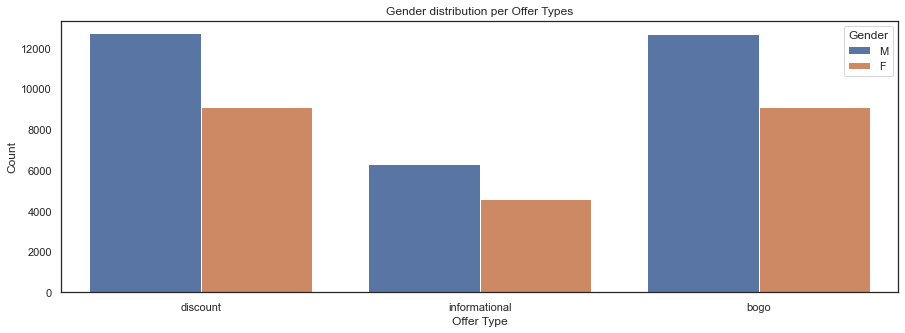

In [328]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_type", hue= "gender", data=plot_gender)
sns.set(style="white")
plt.title('Gender distribution per Offer Types')
plt.ylabel('Count')
plt.xlabel('Offer Type')
plt.legend(title='Gender')

# 4. Data Modeling

## 4.1 Additional Data Processing

In [329]:
# create dummies for categorical variables
df_clean_dummy = create_dummies(df_merged, ['offer_type', 'gender', 'age_group'])

In [330]:
df_clean_dummy.head()

,user_id,offer_id,offer_success,age,income,membership_days,reward,difficulty,duration,email,...,offer_type_bogo,offer_type_discount,offer_type_informational,gender_F,gender_M,gender_O,age_group_20-45,age_group_46-60,age_group_61-80,age_group_under 20
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,33,72000.0,2173,2,10,7,1,...,0,1,0,0,1,0,1,0,0,0
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,0,19,65000.0,2428,2,10,7,1,...,0,1,0,1,0,0,0,0,0,1
2,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,0,56,47000.0,1941,2,10,7,1,...,0,1,0,0,1,0,0,1,0,0
3,00715b6e55c3431cb56ff7307eb19675,2906b810c7d4411798c6938adc9daaa5,1,58,119000.0,1943,2,10,7,1,...,0,1,0,1,0,0,0,1,0,0
4,00840a2ca5d2408e982d56544dc14ffd,2906b810c7d4411798c6938adc9daaa5,1,26,61000.0,3025,2,10,7,1,...,0,1,0,0,1,0,1,0,0,0


In [331]:
# normalize numerica values
def normalize_numericals(df, num_columns):
    """
    Normalize numerical variables using MinMaxScaler
    
    Parameters
    ----------
    df: input data frame
    num_columns: list of categorical variables
    
    Returns
    -------
    df: data frame with categorical variables transformed into dummy variables
    
    """
    scaler = MinMaxScaler() # default=(0, 1)
    df[num_columns] = scaler.fit_transform(df[num_columns])
    
    return df

In [332]:
num_cols = ['income', 'difficulty', 'duration', 'reward', 'membership_days']
df_clean_num = normalize_numericals(df_clean_dummy, num_cols)
df_clean_num.head()

,user_id,offer_id,offer_success,age,income,membership_days,reward,difficulty,duration,email,...,offer_type_bogo,offer_type_discount,offer_type_informational,gender_F,gender_M,gender_O,age_group_20-45,age_group_46-60,age_group_61-80,age_group_under 20
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,33,0.466667,0.252880,0.2,0.5,0.571429,1,...,0,1,0,0,1,0,1,0,0,0
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,0,19,0.388889,0.392759,0.2,0.5,0.571429,1,...,0,1,0,1,0,0,0,0,0,1
2,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,0,56,0.188889,0.125617,0.2,0.5,0.571429,1,...,0,1,0,0,1,0,0,1,0,0
3,00715b6e55c3431cb56ff7307eb19675,2906b810c7d4411798c6938adc9daaa5,1,58,0.988889,0.126714,0.2,0.5,0.571429,1,...,0,1,0,1,0,0,0,1,0,0
4,00840a2ca5d2408e982d56544dc14ffd,2906b810c7d4411798c6938adc9daaa5,1,26,0.344444,0.720241,0.2,0.5,0.571429,1,...,0,1,0,0,1,0,1,0,0,0


In [333]:
df_clean_num.isnull().sum()

user_id                     0
offer_id                    0
offer_success               0
age                         0
income                      0
membership_days             0
reward                      0
difficulty                  0
duration                    0
email                       0
mobile                      0
social                      0
web                         0
offer_type_bogo             0
offer_type_discount         0
offer_type_informational    0
gender_F                    0
gender_M                    0
gender_O                    0
age_group_20-45             0
age_group_46-60             0
age_group_61-80             0
age_group_under 20          0
dtype: int64

In [340]:
df_clean = df_clean_num.dropna()

In [341]:
df_clean.describe()

,offer_success,age,income,membership_days,reward,difficulty,duration,email,mobile,social,...,offer_type_bogo,offer_type_discount,offer_type_informational,gender_F,gender_M,gender_O,age_group_20-45,age_group_46-60,age_group_61-80,age_group_under 20
count,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.0,55222.000000,55222.000000,...,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000
mean,0.335627,54.349969,0.393207,0.285942,0.420474,0.385928,0.501177,1.0,0.898808,0.599181,...,0.399515,0.400547,0.199938,0.413024,0.573051,0.013926,0.280903,0.333128,0.372243,0.013726
std,0.472213,17.392733,0.240293,0.230027,0.340230,0.277399,0.315094,0.0,0.301585,0.490069,...,0.489803,0.490014,0.399957,0.492381,0.494639,0.117183,0.449444,0.471336,0.483407,0.116354
min,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,42.000000,0.211111,0.113549,0.200000,0.250000,0.285714,1.0,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,55.000000,0.366667,0.195831,0.500000,0.500000,0.571429,1.0,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,66.000000,0.555556,0.436643,0.500000,0.500000,0.571429,1.0,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,101.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [335]:
df_clean.shape

(18534, 24)

## 4.1 Split Data into Train and Test

In [359]:
data = df_clean.drop(columns = 'age')
y = data['offer_success']
X = data[['income', 'membership_days', 'gender_F', 'gender_M', 'age_group_20-45', 'age_group_46-60', 'age_group_61-80', 'age_group_under 20']]


In [360]:
#split data into 80/20 proportion into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state = 50 )

We start by training a logistic regression to predict customer response to the offers

# 5. Training model

In [361]:
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics 

## 5.1 Training Logistic Regression

In [395]:
#initiating logistic regression
clf_A =  LogisticRegression(solver='liblinear') 

In [396]:
#training data
clf_A.fit(X_train,y_train) 

LogisticRegression(solver='liblinear')

In [397]:
#predicting
y_pred=clf_A.predict(X_test)

In [398]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

## 5.2 Model Evaluation using Confusion Matrix

In [399]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred) 

In [400]:
cnf_matrix

array([[7114,  237],
       [3521,  173]])

In [401]:
#visualisation of cnf_matrix

Text(0.5, 257.44, 'Predicted label')

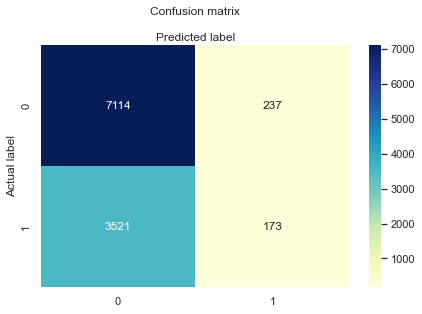

In [402]:
class_names=[0,1] # name  of classes 
fig, ax = plt.subplots() 
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names) 

# create heatmap 

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') 
ax.xaxis.set_label_position("top") 
plt.tight_layout() 
plt.title('Confusion matrix', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')

In [403]:
#metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) 

print("Precision:",metrics.precision_score(y_test, y_pred)) 

print("Recall:",metrics.recall_score(y_test, y_pred)) 

Accuracy: 0.6597555454956994
Precision: 0.4219512195121951
Recall: 0.0468327016783974


As metrics for model evaluation we will use accuracy and f1 score. 

In [404]:
def train_test(clf):
    """
    Return train and test F1 score along with the model name
       
    Parameters
    --------
    clf: estimator instance
    
    Returns
    --------
    train_f1: train data F1 score
    test_f1: test data F1 score
    name: model name
       
    """
    train_prediction =  (clf.fit(X_train, y_train)).predict(X_train)
    test_predictions = (clf.fit(X_train, y_train)).predict(X_test)
    train_f1 =  accuracy_score(y_train, train_prediction)*100
    test_f1= fbeta_score(y_test, test_predictions, beta = 0.5, average='micro' )*100
    name = clf.__class__.__name__
    
    return train_f1, test_f1, name

In [387]:
a_train_f1, a_test_f1, a_model = train_test(clf_A)

In [405]:
log_reg = {'Benchmark Model': [ a_model],'train F1 score':[a_train_f1], 'test F1 score': [a_test_f1]}
benchmark = pd.DataFrame(log_reg)

In [406]:
benchmark

,Benchmark Model,train F1 score,test F1 score
0,LogisticRegression,66.084161,65.975555


**Evaluation:** The model has a quite low accuracy of 0.66. Meaning, only around 66% offer_success events are predicted correctly. Precision is only 0.42. Meaning, the offer_success event equal to 1 is predicted correctly in only 42% of the use cases. Recall value is 0.047 - meaning that the model has a low ability to predict offer_success=1 events

# 6. Model Improvement

We will try to more different algorithms to train the model: RandomForestClassifier and DecisionTreeClassifier. Afterwards we will compare the models and select the model with the highest test F1 score.

In [428]:
clf_B = RandomForestClassifier(random_state = 20)
b_train_f1, b_test_f1, b_model = train_test(clf_B)


In [429]:
clf_C = DecisionTreeClassifier(random_state = 20)
c_train_f1, c_test_f1, c_model = train_test(clf_C)


In [431]:
models = {'Model': ['Logistic Regression (Benchmark)', b_model, c_model], 
          'train F1 score ':[a_train_f1, b_train_f1, c_train_f1], 
          'test F1 score': [a_test_f1 , b_test_f1, c_test_f1]}
          
comp = pd.DataFrame(models)

In [432]:
comp

,Model,train F1 score,test F1 score
0,Logistic Regression (Benchmark),66.084161,65.975555
1,RandomForestClassifier,78.434479,61.303757
2,DecisionTreeClassifier,78.434479,62.426437


# 6. Conclusion

According to the comparison table the highest training test score was achieved by the Random Forest and Decision Tree classifiers. However, the highest test score was achieved by logistic regression. Meaning, we would use logistic regression in order to predict response to the offer. 

However, the f1 score is not that great for all models and it would make sense to consider further steps to improve the fit:
1. Introduce further features (the model we trained is rather basic and introduction of further features could improve the fit)
2. Consider further classifiers like XGBoost or LightGBM to train the model.
Most likely the combination of two would help to improve the fit. 


The not-so-perfect model fit could also suggest that only demographic features that we used to train the model are not perfect predictors of offer performance and further variables can impact offer performance (e.g. offer type, reward etc.)


Further recommendations:
- A deeper exploratory data analysis could also provide hints on how different income groups interact with different offers in order to develop a set of recommendations for further use.
- Another recommendation would be to reconsider data collection in the app. At the moment the transaction value attribution to a specific offer is rather challenging. Rethinking and improving data collection could also possibly improve model prediction in the future.